### Image Classification using CNN

In [2]:
# Import libraries and packages
import matplotlib as plt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D, AveragePooling2D, Flatten
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import TensorBoard
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os
import time   
import datetime
import warnings

%load_ext tensorboard
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

## Load data from disk

In [3]:
import zipfile

animals = zipfile.ZipFile(r"D:\ashwin\sy_sem1_prac\dl\4_ann_image_classification\animals.zip", mode="r")
# initialize the data and labels
print("[INFO] loading images...")
time1 = time.time()   # to measure time taken
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(animals.namelist())   # data folder with 3 categorical folders
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    if (".jpg" in imagePath or ".JPG" in imagePath):
        # load the image, resize the image to be 32x32 pixels (ignoring aspect ratio), 
        # flatten the 32x32x3=3072 pixel image into a list, and store the image in the data list
        buf = animals.read(imagePath)
        np_buf = np.frombuffer(buf, np.uint8)
        image = cv2.imdecode(np_buf, 1)
        image = cv2.resize(image, (32, 32))
        data.append(image)

        # extract the class label from the image path and update the labels list
        label = imagePath.split("/")[-2]
        labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken
print("done")

[INFO] loading images...
Time taken: 4.0 seconds
done


## Split data for training and validation

In [4]:
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=SEED)

In [5]:
# convert the labels from integers/categories to vectors 
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   
testY = lb.transform(testY)        

## Define neural network architecture using Keras

In [38]:
from keras.applications import EfficientNetB7, VGG16
conv_base_vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classes=3   
)
conv_base_eff = EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classes=3
)

58889256/58889256 [==============================] - 3s 0us/step


In [39]:
model = Sequential()   # input layer 3072 as there are 32x32x3=3072 pixels in a flattened input
conv_base_vgg.trainable = False 
model.add(conv_base_vgg)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256, activation='leaky_relu'))
model.add(Dense(units=64, activation='leaky_relu'))                       
model.add(Dense(len(lb.classes_), activation="softmax"))   

# define the 3072-1024-512-3 architecture using Keras

model = Sequential()   # input layer 3072 as there are 32x32x3=3072 pixels in a flattened input 
model.add(Conv2D(filters=32, kernel_size=(3, 3),  activation='leaky_relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(AveragePooling2D())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='leaky_relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='leaky_relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256, activation='leaky_relu'))                        
model.add(Dense(len(lb.classes_), activation="softmax"))            # output layer with number of possible class labels

In [40]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization_3 (Batc  (None, 1, 1, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                      

In [41]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 200
 
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)  
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] training network...


In [42]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken

H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

Epoch 1/200
75/75 [==============================] - 2s 14ms/step - loss: 1.1306 - accuracy: 0.4604 - val_loss: 0.9417 - val_accuracy: 0.5300
Epoch 2/200
75/75 [==============================] - 1s 8ms/step - loss: 0.9067 - accuracy: 0.5529 - val_loss: 0.8642 - val_accuracy: 0.5833
Epoch 3/200
75/75 [==============================] - 1s 8ms/step - loss: 0.8509 - accuracy: 0.5979 - val_loss: 0.8162 - val_accuracy: 0.6133
Epoch 4/200
75/75 [==============================] - 1s 9ms/step - loss: 0.8453 - accuracy: 0.5917 - val_loss: 0.7857 - val_accuracy: 0.6117
Epoch 5/200
75/75 [==============================] - 1s 9ms/step - loss: 0.8024 - accuracy: 0.6175 - val_loss: 0.7602 - val_accuracy: 0.6250
Epoch 6/200
75/75 [==============================] - 1s 9ms/step - loss: 0.7974 - accuracy: 0.6217 - val_loss: 0.7457 - val_accuracy: 0.6300
Epoch 7/200
75/75 [==============================] - 1s 9ms/step - loss: 0.7853 - accuracy: 0.6321 - val_loss: 0.7344 - val_accuracy: 0.6383
Epoch 8/200


## Evaluate Model

In [47]:
# evaluate the network
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

19/19 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

        cats       0.59      0.62      0.61       176
        dogs       0.66      0.55      0.60       215
       panda       0.76      0.86      0.80       209

    accuracy                           0.68       600
   macro avg       0.67      0.68      0.67       600
weighted avg       0.67      0.68      0.67       600



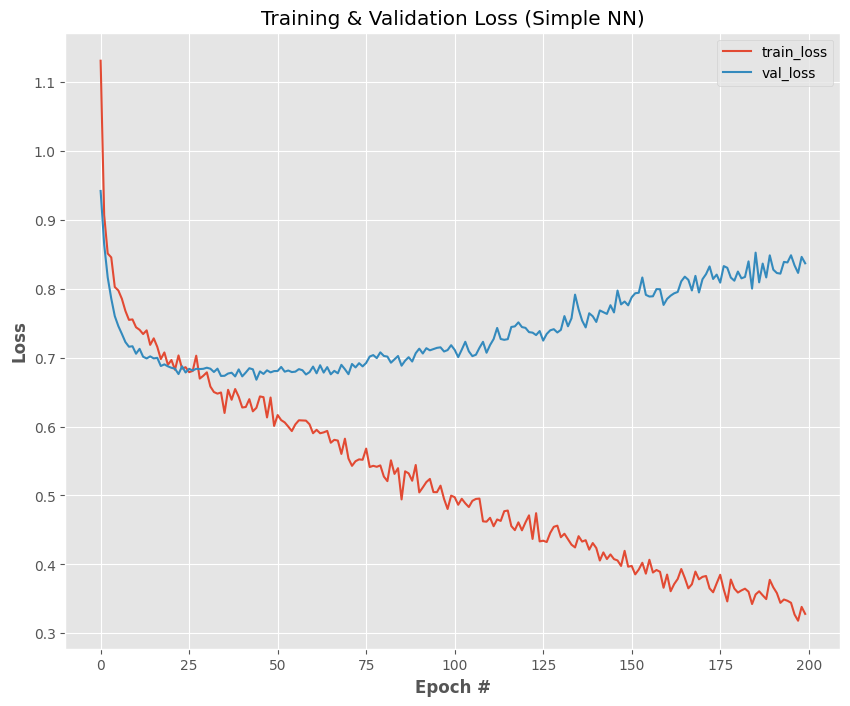

In [45]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

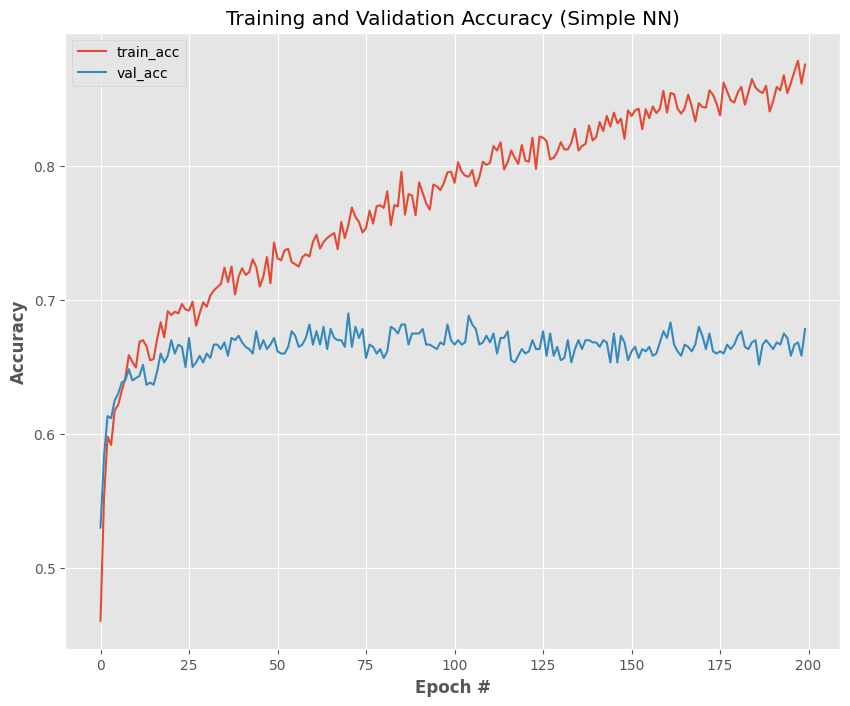

In [46]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Simple NN)")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

## Prediction

In [93]:
# load the input image and resize it to the target spatial dimensions
#image = cv2.imread(r"D:\ashwin\sy_sem1_prac\dl\4_ann_image_classification\dog_test.jpg")
#image = cv2.imread(r"D:\ashwin\sy_sem1_prac\dl\4_ann_image_classification\cat_test.jpg")
image = cv2.imread(r"D:\ashwin\sy_sem1_prac\dl\4_ann_image_classification\panda_test.jpg")

output = image.copy()
image = cv2.resize(image, (32, 32))

# scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

# for a simple fully-connected network, flatten the image
image = image.flatten()
image = image.reshape((1, image.shape[0]))


# make a prediction on the image
preds = model.predict(image)

# find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

# draw the class label + probability on the output image
text = "{}: {:.1f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# show the output image
cv2.imshow("Image", output)
cv2.waitKey(0)
  
# closing all open windows
cv2.destroyAllWindows()
cv2.imwrite('grayscale.jpg', output)


AttributeError: 'NoneType' object has no attribute 'copy'

## Save model

In [86]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        1216      
                                                                 
 average_pooling2d_10 (Avera  (None, 14, 14, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 8)         1160      
                                                                 
 average_pooling2d_11 (Avera  (None, 6, 6, 8)          0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 288)               0         
                                                                 
 dense_16 (Dense)            (None, 256)              

In [ ]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save('simple_NN_model.h5')
f = open('simple_NN_label_bin', "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [ ]:
# plot the prediction probability for each category
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
plt.figure(figsize = [10,5])   # [width, height]

x = [ lb.classes_[0], lb.classes_[1], lb.classes_[2] ]
y = [ preds[0][0], preds[0][1], preds[0][2] ]
plt.barh(x, y, color='olive')

ticks_x = np.linspace(0, 1, 11)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks( size=15, color='navy' )
for i, v in enumerate(y):
    plt.text(v, i, "  "+str((v*100).round(1))+"%", color='blue', va='center', fontweight='bold')

plt.title('Prediction Probability', family='serif', fontsize=15, style='italic', weight='bold', color='olive', loc='center', rotation=0)
plt.xlabel('Probability', fontsize=12, weight='bold', color='blue')
plt.ylabel('Category', fontsize=12, weight='bold', color='navy')

NameError: name 'preds' is not defined

<Figure size 1000x500 with 0 Axes>